In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [3]:
def loadData(outputFile,inputFile):
    taxiData=pd.read_csv(inputFile)
    taxiData['TIMESTAMP'] = taxiData['TIMESTAMP'].astype('int')
    taxiData['TIMESTAMP']=taxiData['TIMESTAMP'].apply(lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
    taxiData['TIMESTAMP'] = pd.to_datetime(taxiData['TIMESTAMP'])
    taxiData['TIMESTAMP']=taxiData['TIMESTAMP'].dt.round('60min')
    taxiData['DATE']=pd.to_datetime(taxiData['TIMESTAMP']).dt.date
    timeData=taxiData.groupby(['DATE']).size().to_frame(name='TAXI_COUNT').reset_index()
    OUTPUT=timeData.iloc[:-1,:]
    OUTPUT.to_csv(outputFile)

In [4]:
def processData(outFile):
    loadData = pd.read_csv(outFile, header=0, index_col=0, parse_dates=True, squeeze=True)
    loadData['TAXI_COUNT'] = loadData['TAXI_COUNT'].values
    loadData['TAXI_COUNT'] = loadData['TAXI_COUNT'].astype('float32')
    loadData = loadData.iloc[: , 1:]
    scaler = MinMaxScaler(feature_range=(0, 1))
    taxiDataset_obj=scaler.fit(loadData)
    loadData = scaler.fit_transform(loadData)
    loadData=loadData.reshape(len(loadData),)
    return loadData,taxiDataset_obj

In [5]:
def dataPreparation(taxiData,seqLen,numOfEntry):
    feature = []
    label = []
    for i in range(numOfEntry):
        feature.append(taxiData[i:i+seqLen]) 
        label.append(taxiData[i+seqLen])
    feature = np.array(feature) 
    feature = np.expand_dims(feature, axis=2) 
    label = np.array(label) 
    label = np.expand_dims(label, axis=1)
    return feature,label

In [6]:
def activationFunction(x):
    return 1 / (1 + np.exp(-x))

In [7]:
def predictLoss(feature,label):
    loss = 0.0
    for i in range(label.shape[0]):
        currentFeature, currentLabel = feature[i], label[i]                    
        preStates = np.zeros((noOfHiddenLayer, 1))   
        for t in range(seqLen):
            currentInput = np.zeros(currentFeature.shape)    
            currentInput[t] = currentFeature[t]              
            mulMatrixInpHid = np.dot(inpToHidWeight, currentInput)     
            mulMatrixHidHid = np.dot(hidToHidWeight, preStates)         
            matrixAdd = mulMatrixHidHid + mulMatrixInpHid   
            currentState = activationFunction(matrixAdd)   
            mulMatrixHidOut = np.dot(hidToOutWeight, currentState) 
            preStates = currentState 


        lossPerRecord = (currentLabel - mulMatrixHidOut)**2 / 2
        loss += lossPerRecord
    return loss

In [9]:
def forwardPass(preStates,layersResult,currentFeature):
    for t in range(seqLen):
        currentInput = np.zeros(currentFeature.shape)
        currentInput[t] = currentFeature[t]
        mulMatrixInpHid = np.dot(inpToHidWeight, currentInput)
        mulMatrixHidHid = np.dot(hidToHidWeight, preStates)
        matrixAdd = mulMatrixHidHid + mulMatrixInpHid
        currentState = activationFunction(matrixAdd)
        mulMatrixHidOut = np.dot(hidToOutWeight, currentState)
        layersResult.append({'currentState':currentState, 'preStates':preStates})
        preStates = currentState
    return preStates,layersResult,mulMatrixHidOut,mulMatrixInpHid,mulMatrixHidHid,matrixAdd

In [10]:
def trainModel(feature,label,inpToHidWeight,hidToHidWeight,hidToOutWeight):
    for i in range(label.shape[0]):
            currentFeature, currentLabel = feature[i], label[i]
            layersResult = []
            preStates = np.zeros((noOfHiddenLayer, 1))
            dinpToHidWeight = np.zeros(inpToHidWeight.shape)
            dhidToOutWeight = np.zeros(hidToOutWeight.shape)
            dhidToHidWeight= np.zeros(hidToHidWeight.shape)
            
            dinpToHidWeightT = np.zeros(inpToHidWeight.shape)
            dhidToOutWeightT = np.zeros(hidToOutWeight.shape)
            dhidToHidWeightT = np.zeros(hidToHidWeight.shape)
            
            dinpToHidWeightI = np.zeros(inpToHidWeight.shape)
            dhidToHidWeightI = np.zeros(hidToHidWeight.shape)
            
            
            preStates,layersResult,mulMatrixHidOut,mulMatrixInpHid,mulMatrixHidHid,matrixAdd=forwardPass(preStates,layersResult,currentFeature)
        
            dmulMatrixHidOut = (mulMatrixHidOut - currentLabel)
    
            for t in range(seqLen):
                dhidToOutWeightT = np.dot(dmulMatrixHidOut, np.transpose(layersResult[t]['currentState']))
                dCurrentStateVector = np.dot(np.transpose(hidToOutWeight), dmulMatrixHidOut)
                
                dCurrentState = dCurrentStateVector
                dmatrixAdd = matrixAdd * (1 - matrixAdd) * dCurrentState
                
                dmulMatrixHidHid = dmatrixAdd * np.ones_like(mulMatrixHidHid)

                dpreStates = np.dot(np.transpose(hidToHidWeight), dmulMatrixHidHid)


                for i in range(t-1, max(-1, t-bpttTruncate-1), -1):
                    dCurrentState = dCurrentStateVector + dpreStates
                    dmatrixAdd = matrixAdd * (1 - matrixAdd) * dCurrentState

                    dmulMatrixHidHid = dmatrixAdd * np.ones_like(mulMatrixHidHid)
                    dmulMatrixInpHid = dmatrixAdd * np.ones_like(mulMatrixInpHid)

                    dhidToHidWeightI = np.dot(hidToHidWeight, layersResult[t]['preStates'])
                    dpreStates = np.dot(np.transpose(hidToHidWeight), dmulMatrixHidHid)

                    currentInput = np.zeros(currentFeature.shape)
                    currentInput[t] = currentFeature[t]
                    dinpToHidWeightI = np.dot(inpToHidWeight, currentInput)
                    dx = np.dot(np.transpose(inpToHidWeight), dmulMatrixInpHid)

                    dinpToHidWeightT += dinpToHidWeightI
                    dhidToHidWeightT += dhidToHidWeightI

                dhidToOutWeight += dhidToOutWeightT
                dinpToHidWeight += dinpToHidWeightT
                dhidToHidWeight+= dhidToHidWeightT
                if dinpToHidWeight.max() > gradientMaxClipping:
                    dinpToHidWeight[dinpToHidWeight > gradientMaxClipping] = gradientMaxClipping
                if dhidToOutWeight.max() > gradientMaxClipping:
                    dhidToOutWeight[dhidToOutWeight > gradientMaxClipping] = gradientMaxClipping
                if dhidToHidWeight.max() > gradientMaxClipping:
                    dhidToHidWeight[dhidToHidWeight> gradientMaxClipping] = gradientMaxClipping
                    
                
                if dinpToHidWeight.min() < gradientMinClipping:
                    dinpToHidWeight[dinpToHidWeight < gradientMinClipping] = gradientMinClipping
                if dhidToOutWeight.min() < gradientMinClipping:
                    dhidToOutWeight[dhidToOutWeight < gradientMinClipping] = gradientMinClipping
                if dhidToHidWeight.min() < gradientMinClipping:
                    dhidToHidWeight[dhidToHidWeight< gradientMinClipping] = gradientMinClipping
            
            inpToHidWeight -= learningRate * dinpToHidWeight
            hidToOutWeight -= learningRate * dhidToOutWeight
            hidToHidWeight -= learningRate * dhidToHidWeight
    return inpToHidWeight,hidToHidWeight,hidToOutWeight

In [50]:
def RNN(inpToHidWeight,hidToHidWeight,hidToOutWeight):
    TrainValue=[]
    TestValue=[]
    for epoch in range(noOfEpoch):
        Trainloss = predictLoss(feature_Train,label_Train)
        Trainloss = Trainloss / float(label_Train[0].shape[0])
       
        valueLoss = predictLoss(feature_Test,label_Test)
        valueLoss = valueLoss / float(label_Test[0].shape[0])

        print('Current Epoch: ', epoch + 1, ',Train Loss: ', Trainloss, ', Test Loss: ', valueLoss)
        TrainValue.append(Trainloss[:, 0])
        TestValue.append(valueLoss[:, 0])
        inpToHidWeight,hidToHidWeight,hidToOutWeight=trainModel(feature_Train,label_Train,inpToHidWeight,hidToHidWeight,hidToOutWeight)
    plt.plot(TrainValue, 'green',label="TrainError")
    plt.plot(TestValue, 'red',label="TestError")
    plt.title("Error vs Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc="upper right")
    plt.show()
    return inpToHidWeight,hidToHidWeight,hidToOutWeight

In [57]:
def modelEvalute(label,feature,modelType,inpToHidWeight,hidToHidWeight,hidToOutWeight):
    predictions = []
    for i in range(label.shape[0]):
        currentFeature, currentLabel = feature[i], label[i]
        preStates = np.zeros((noOfHiddenLayer, 1))
        for t in range(seqLen):
            mulMatrixInpHid = np.dot(inpToHidWeight, currentFeature)
            mulMatrixHidHid = np.dot(hidToHidWeight, preStates)
            matrixAdd = mulMatrixHidHid + mulMatrixInpHid
            currentState = activationFunction(matrixAdd)
            mulMatrixHidOut = np.dot(hidToOutWeight, currentState)
            preStates = currentState

        predictions.append(mulMatrixHidOut)
        
    predictions = np.array(predictions)
    predictions = taxiDataset_obj.inverse_transform(predictions[:, 0])
    label = taxiDataset_obj.inverse_transform(label)
    trainScore = math.sqrt(mean_squared_error(predictions[:,0], label[:,0]))
    print(str(modelType)+' Score: %.2f RMSE' % (trainScore))
    plt.plot(predictions[:, 0], 'green',label="Prediction")
    plt.plot(label[:, 0], 'red',label=str(modelType))
    plt.title("Taxi Demand vs Days›")
    plt.xlabel("Days")
    plt.ylabel("Taxi Demand")
    plt.legend(loc="upper right")
    plt.show()

In [41]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
ga = GoogleAuth()
ga.credentials = GoogleCredentials.get_application_default()
dr = GoogleDrive(ga)
url='https://drive.google.com/file/d/1TpBZ8hSBdENDaxFfcM7TB20VHpCm4soj/view?usp=sharing'
id = url.split('/')[-2]
downloaded = dr.CreateFile({'id':id})
downloaded.GetContentFile('train.csv')  
loadData('outTest.csv','train.csv')
taxiDataset,taxiDataset_obj=processData('outTest.csv')

In [42]:
trainSize  = int(len(taxiDataset) * 0.8)
testSize = len(taxiDataset) - trainSize
train, test = taxiDataset[0:trainSize], taxiDataset[trainSize:len(taxiDataset)]

In [58]:
seqLen = 30
learningRate = 0.0001    
noOfEpoch = 100              
noOfHiddenLayer = 90         
outputUnit = 1
numOfEntry = len(taxiDataset) - seqLen 
feature_Train,label_Train=dataPreparation(train,seqLen,len(train)-seqLen)
feature_Test,label_Test=dataPreparation(test,seqLen,len(test)-seqLen)
bpttTruncate = 5
gradientMinClipping = -1
gradientMaxClipping = 1

In [59]:
inpToHidWeight = np.random.uniform(0, 1, (noOfHiddenLayer, seqLen)) #  U
hidToHidWeight = np.random.uniform(0, 1, (noOfHiddenLayer, noOfHiddenLayer)) #  W
hidToOutWeight = np.random.uniform(0, 1, (outputUnit, noOfHiddenLayer)) #  V

Current Epoch:  1 ,Train Loss:  [[290387.42883062]] , Test Loss:  [[47475.39320144]]
Current Epoch:  2 ,Train Loss:  [[262028.94889534]] , Test Loss:  [[42830.34250054]]
Current Epoch:  3 ,Train Loss:  [[235127.23192806]] , Test Loss:  [[38424.37885163]]
Current Epoch:  4 ,Train Loss:  [[209682.27792878]] , Test Loss:  [[34257.50225472]]
Current Epoch:  5 ,Train Loss:  [[185694.0868975]] , Test Loss:  [[30329.71270981]]
Current Epoch:  6 ,Train Loss:  [[163162.6588342]] , Test Loss:  [[26641.0102169]]
Current Epoch:  7 ,Train Loss:  [[142087.99373872]] , Test Loss:  [[23191.39477596]]
Current Epoch:  8 ,Train Loss:  [[122470.09160962]] , Test Loss:  [[19980.86638676]]
Current Epoch:  9 ,Train Loss:  [[104308.95243346]] , Test Loss:  [[17009.42504714]]
Current Epoch:  10 ,Train Loss:  [[87604.5760874]] , Test Loss:  [[14277.07073728]]
Current Epoch:  11 ,Train Loss:  [[72356.96146324]] , Test Loss:  [[11783.80327808]]
Current Epoch:  12 ,Train Loss:  [[58566.09872546]] , Test Loss:  [[9

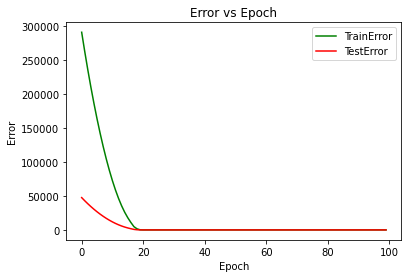

Train Score: 2966.66 RMSE


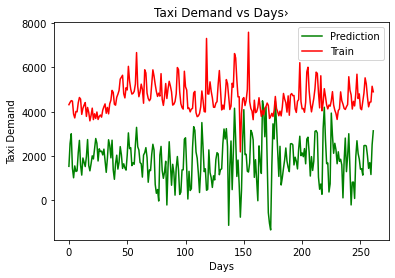

Test Score: 3894.99 RMSE


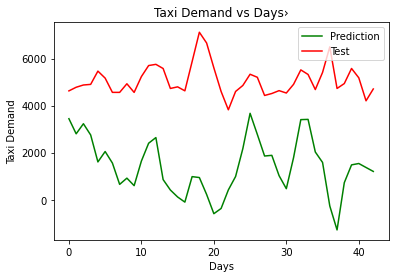

In [60]:
inpToHidWeight,hidToHidWeight,hidToOutWeight=RNN(inpToHidWeight,hidToHidWeight,hidToOutWeight)
modelEvalute(label_Train,feature_Train,'Train',inpToHidWeight,hidToHidWeight,hidToOutWeight)
modelEvalute(label_Test,feature_Test,'Test',inpToHidWeight,hidToHidWeight,hidToOutWeight)